In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import * 
from tensorflow.keras.activations import * 
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import os
from tqdm import tqdm
import numpy as np
import random
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-04-11 23:21:27.395644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744413687.601757      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744413687.661534      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def weighted_bincrossentropy(y_true, y_pred, weight_zero=0.25, weight_one=1.0):
    bce = K.binary_crossentropy(y_true, y_pred)
    weights = y_true * weight_one + (1. - y_true) * weight_zero
    return K.mean(weights * bce)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    modulating_factor = K.pow(1. - p_t, gamma)
    
    return K.mean(-alpha_factor * modulating_factor * K.log(p_t))

def combo_loss(y_true, y_pred):
    return (
        0.4 * weighted_bincrossentropy(y_true, y_pred) +
        0.3 * dice_loss(y_true, y_pred) +
        0.3 * focal_loss(y_true, y_pred)
    )


def down_block(x, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if pool:
        p = MaxPooling2D(pool_size=(2, 2))(x)
        return p, x
    else:
        return x, x

def up_block(x, skip, filters):
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip])
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

def build_unet(input_size=(256, 256, 2), classes=1, dropout=0.2):
    f = [64, 128, 256, 512, 1024]

    inputs = Input(input_size)

    # Encoder
    x, skip1 = down_block(inputs, f[0])     # -> (128, 256)
    x, skip2 = down_block(x, f[1])          # -> (64, 128)
    x, skip3 = down_block(x, f[2])          # -> (32, 64)
    x, skip4 = down_block(x, f[3])          # -> (16, 32)
    x, _     = down_block(x, f[4], pool=False) # -> (16, 32)

    # Decoder
    x = up_block(x, skip4, f[3])            # -> (32, 64)
    x = up_block(x, skip3, f[2])            # -> (64, 128)
    x = up_block(x, skip2, f[1])            # -> (128, 256)
    x = up_block(x, skip1, f[0])            # -> (256, 512)
    x = Dropout(dropout)(x)

    # Final conv
    x = Conv2D(1, 1, activation='sigmoid')(x)  # -> (256, 256, 1)

    return Model(inputs, x, name='Symmetric_UNet')

In [4]:
# Set these paths
input_dir = "/kaggle/input/floodmapping2/kaggle/working/dataset/input"
target_dir = "/kaggle/input/floodmapping2/kaggle/working/dataset/target"

aug_input_dir = "/kaggle/working/augmented/input"
aug_target_dir = "/kaggle/working/augmented/target"
os.makedirs(aug_input_dir, exist_ok=True)
os.makedirs(aug_target_dir, exist_ok=True)

# Parameters
num_aug_per_sample = 3  # how many augmented versions per image

# Simple augmentations
def augment_pair(x, y):
    # Random flip
    if random.random() < 0.5:
        x = np.fliplr(x)
        y = np.fliplr(y)
    if random.random() < 0.5:
        x = np.flipud(x)
        y = np.flipud(y)

    # Random 90-degree rotation
    k = random.choice([0, 1, 2, 3])
    x = np.rot90(x, k)
    y = np.rot90(y, k)

    # Optional: add more augmentations like noise, brightness, blur, etc.
    
    return x, y

# Get all .npy paths
input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.npy')])
target_paths = sorted([os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith('.npy')])

# Loop through and save augmented data
for idx, (x_path, y_path) in enumerate(tqdm(zip(input_paths, target_paths), total=len(input_paths))):
    x = np.load(x_path)
    y = np.load(y_path)

    base_name = os.path.splitext(os.path.basename(x_path))[0]

    # Save original
    np.save(os.path.join(aug_input_dir, f"{base_name}_orig.npy"), x)
    np.save(os.path.join(aug_target_dir, f"{base_name}_orig.npy"), y)

    # Generate augmentations
    for i in range(num_aug_per_sample):
        x_aug, y_aug = augment_pair(np.copy(x), np.copy(y))
        np.save(os.path.join(aug_input_dir, f"{base_name}_aug{i}.npy"), x_aug)
        np.save(os.path.join(aug_target_dir, f"{base_name}_aug{i}.npy"), y_aug)

100%|██████████| 880/880 [00:23<00:00, 37.55it/s]


In [5]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        inputs, targets = self.dataset[0]  # Get first batch
        predictions = self.model.predict(inputs)

        # Extract first item from batch
        input_img = inputs[0]
        before = input_img[:, :, 0]
        after = input_img[:, :, 1]
        target_mask = targets[0].squeeze()
        pred_mask = predictions[0].squeeze()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.title("Before")
        plt.imshow(before, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("After")
        plt.imshow(after, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Ground Truth")
        plt.imshow(target_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Prediction")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()



class FloodDataset(Sequence):
    def __init__(self, input_paths, target_paths, batch_size=8, augment=False):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.input_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.input_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.target_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        inputs, targets = [], []
        for x_path, y_path in zip(batch_x, batch_y):
            x = np.load(x_path)   # shape: (256, 256, 2)
            y = np.load(y_path)   # shape: (256, 256, 1)

            if self.augment:
                x, y = self.augment_pair(x, y)

            inputs.append(x)
            targets.append(y)

        return np.array(inputs), np.array(targets)

    def augment_pair(self, x, y):
        # Random horizontal flip
        if random.random() < 0.5:
            x = np.fliplr(x)
            y = np.fliplr(y)

        # Random vertical flip
        if random.random() < 0.5:
            x = np.flipud(x)
            y = np.flipud(y)

        # Random 90-degree rotations
        k = random.choice([0, 1, 2, 3])
        x = np.rot90(x, k)
        y = np.rot90(y, k)

        return x, y


input_dir = "/kaggle/working/augmented/input"
target_dir = "/kaggle/working/augmented/target"

input_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])

train_x, val_x, train_y, val_y = train_test_split(input_paths, target_paths, test_size=0.2, random_state=42)

train_gen = FloodDataset(train_x, train_y, batch_size=4, augment=True)
val_gen = FloodDataset(val_x, val_y, batch_size=4, augment=False)



Inputs shape: (4, 256, 256, 2)
Targets shape: (4, 256, 256, 1)


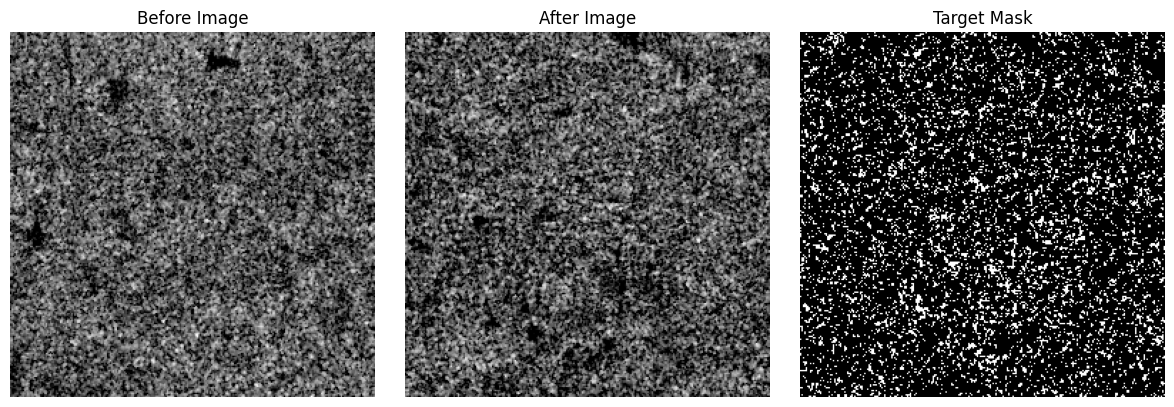

In [6]:
inputs, targets = train_gen[0]

print("Inputs shape:", inputs.shape)   # (batch_size, 256, 256, 2)
print("Targets shape:", targets.shape) # (batch_size, 256, 256, 1)

before = inputs[0, :, :, 0]  # Channel 0
after = inputs[0, :, :, 1]   # Channel 1
target = targets[0].squeeze()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Before Image")
plt.imshow(before, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("After Image")
plt.imshow(after, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target Mask")
plt.imshow(target, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


Model: "Symmetric_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 2)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │          1,216 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_18            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ leaky_re_lu_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 256, 256, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_19            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ leaky_re_lu_19[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 128)  │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_20            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ leaky_re_lu_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 128)  │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_21            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 31,401,921 (119.79 MB)

 Trainable params: 31,390,145 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744413923.751870     108 service.cc:148] XLA service 0x7c4bf8041460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744413923.752644     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744413923.752668     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744413925.178838     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-11 23:25:28.868970: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[4,128,128,12

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepms/step - loss: 0.6185 - mean_io_u_1: 0.333


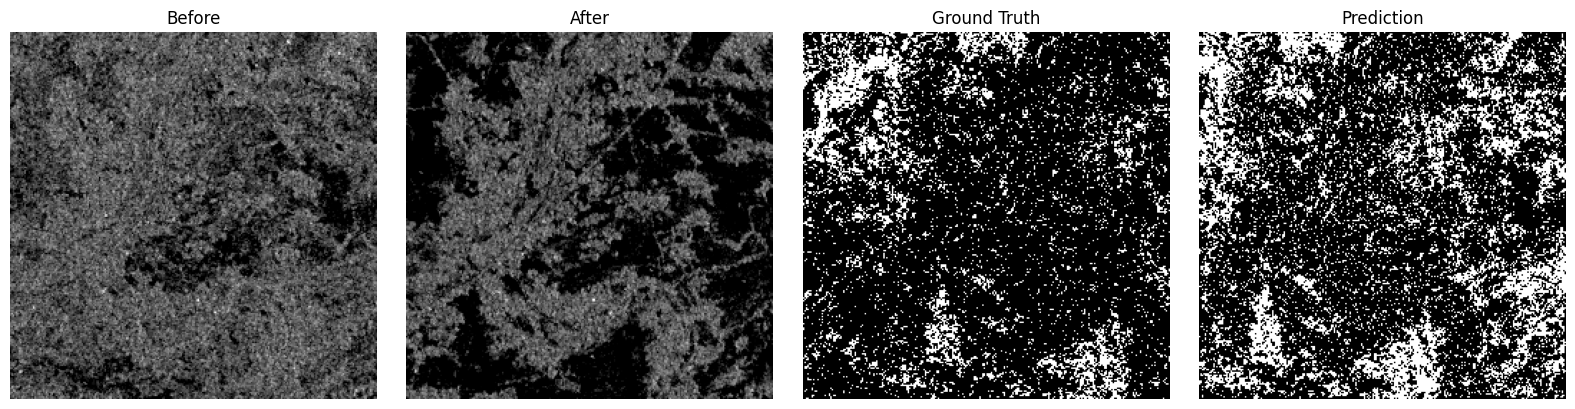


Epoch 1: val_loss improved from inf to 0.50751, saving model to best_unet_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 318s 371ms/step - loss: 0.6185 - mean_io_u_1: 0.3332 - val_loss: 0.5075 - val_mean_io_u_1: 0.4456
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - loss: 0.5283 - mean_io_u_1: 0.383


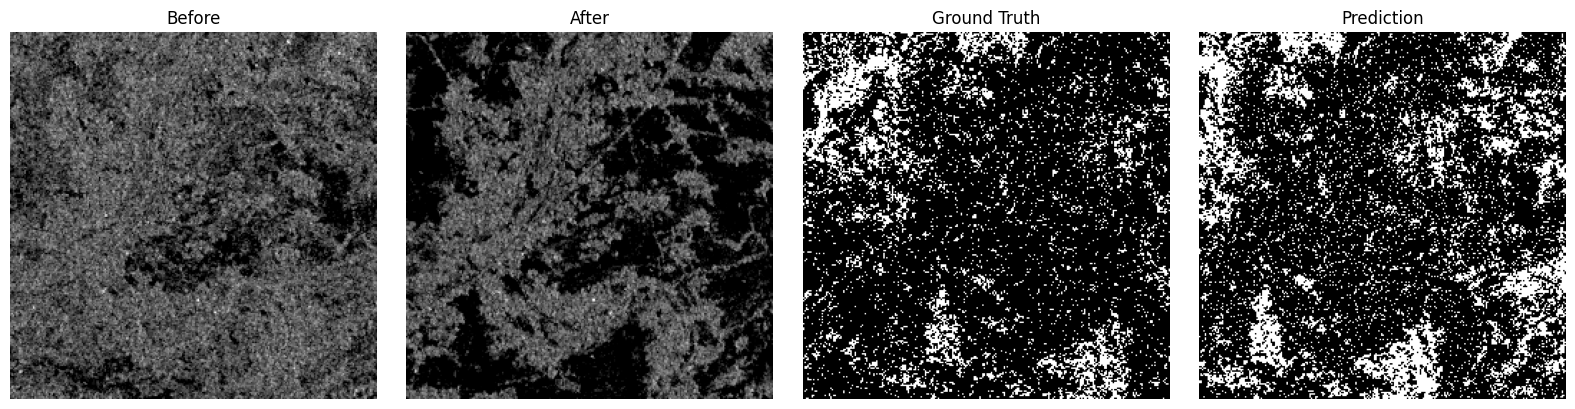


Epoch 2: val_loss did not improve from 0.50751
704/704 ━━━━━━━━━━━━━━━━━━━━ 257s 365ms/step - loss: 0.5283 - mean_io_u_1: 0.3836 - val_loss: 0.5138 - val_mean_io_u_1: 0.4616
Epoch 3/50
298/704 ━━━━━━━━━━━━━━━━━━━━ 2:16 337ms/step - loss: 0.5342 - mean_io_u_1: 0.4703

KeyboardInterrupt: 

In [8]:
# ========== Build & Train Model ==========

model = build_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss= dice_loss,
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)
model.summary()

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_ckpt = ModelCheckpoint(
    'best_unet_model.keras',  # Use .keras instead of .h5
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[DisplayCallback(val_gen), early_stop, model_ckpt]
)